In [1]:
import psfmodels as psfm
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import numpy as np
import tifffile
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
import pandas as pd
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from scipy.optimize import minimize, LinearConstraint, Bounds, differential_evolution, basinhopping, shgo, dual_annealing, direct


import tifffile
from pyotf.phaseretrieval import retrieve_phase
from pyotf.utils import prep_data_for_PR
from skimage.transform import rescale, rotate
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import img_as_uint
from pyotf.utils import prep_data_for_PR, center_data
from pyotf.otf import HanserPSF, apply_aberration, apply_named_aberration, apply_named_aberrations
from skimage.filters import gaussian
from skimage.restoration import denoise_wavelet
from tqdm.auto import tqdm

def get_midline(arr):
    mid_x = arr.shape[1]//2
    return arr[mid_x]

def get_midline_rotate_method(arr):
    mid_x = arr.shape[1]//2
    midline = np.array([rotate(arr, angle, resize = False, clip = True, preserve_range = True)[mid_x] for angle in range(366)]).mean(axis=0)
    return midline

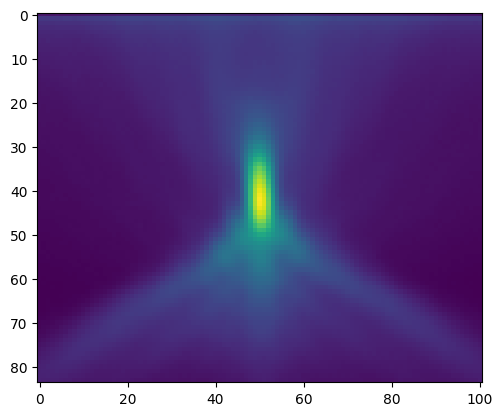

In [86]:
a = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_green.tif")
a = a[np.argwhere(a.sum(axis=(1,2)))][:,0,:,:].astype(int)
a = center_data(a)
#a -= int(np.percentile(a,10))
#a = np.clip(a, 0, np.inf).astype(int)
#a = np.array([gaussian(x, 1) for x in a])
a = a/a.max()
a = img_as_uint(a)
a = a[10:-10,70:-70,70:-70]
plt.imshow(a.sum(axis=1))
target_psf = a
target_psf = prep_data_for_PR(target_psf, multiplier = 0.9)
target_psf = target_psf/target_psf.max()

In [113]:
PSF_function(600, 1.3, 1.4, 2, 0.2)

KeyError: 0.2

In [88]:
target_psf.sum()

6600.468478172634

In [89]:
params = dict(wl=700, na=1.3, ni=1.6, res=43.2, zres=50, vec_corr = "total", condition = "sine")
HanserPSF(**params, size=target_psf.shape[1], zsize=target_psf.shape[0]).PSFi.shape

(84, 101, 101)

In [115]:
def PSF_function(wl, na, ni, vec_corr_idx, condition_idx):
    vec_corr = {0: "x", 1: "y", 2 : "z", 3: "total"}[vec_corr_idx]
    condition_idx = {0: "sine", 1: "herschel"}[condition_idx]
    params = dict(wl=wl, na=na, ni=ni, res=43.2, zres=50, vec_corr = vec_corr, condition = condition_idx)
    synthetic = HanserPSF(**params, size=target_psf.shape[1], zsize=target_psf.shape[0]).PSFi
    return synthetic/synthetic.max()

def error_function(params):
    wl, na, ni, vec_corr_idx, condition_idx = params
    synthetic = PSF_function(wl, na, ni, vec_corr_idx, condition_idx)
    return np.nansum((np.log(target_psf+np.finfo(np.float16).eps) - np.log(synthetic+np.finfo(np.float16).eps)) ** 2)

In [116]:
bounds = Bounds([600, 0.4, 1, 0, 0], [1000, 1.57, 3, 3, 1])
integrality = [False, False, False, True, True]

In [117]:
%%time 
result = differential_evolution(error_function, bounds, workers = 23, disp = True, integrality = integrality)

differential_evolution step 1: f(x)= 518645.87948227616
differential_evolution step 2: f(x)= 315194.29318928125
differential_evolution step 3: f(x)= 315194.29318928125
differential_evolution step 4: f(x)= 315194.29318928125
differential_evolution step 5: f(x)= 315194.29318928125
differential_evolution step 6: f(x)= 315194.29318928125
differential_evolution step 7: f(x)= 302918.9050504851
differential_evolution step 8: f(x)= 295942.2535456306
differential_evolution step 9: f(x)= 295942.2535456306
differential_evolution step 10: f(x)= 295942.2535456306
differential_evolution step 11: f(x)= 295942.2535456306
differential_evolution step 12: f(x)= 295942.2535456306
differential_evolution step 13: f(x)= 295942.2535456306
differential_evolution step 14: f(x)= 292799.1844563106
differential_evolution step 15: f(x)= 292799.1844563106
differential_evolution step 16: f(x)= 292799.1844563106
differential_evolution step 17: f(x)= 292799.1844563106
differential_evolution step 18: f(x)= 292799.184456

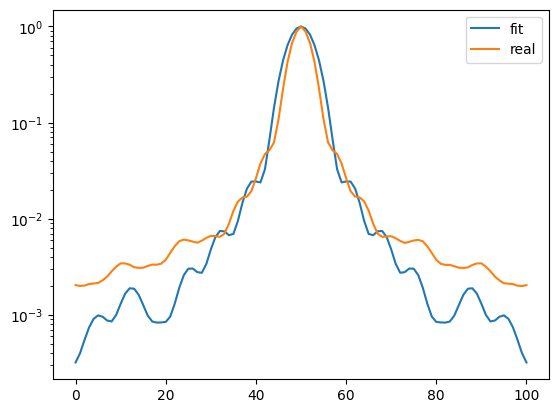

In [121]:
fitted_PSF = PSF_function(*result.x)
mid_z = target_psf.shape[0]//2 
plt.plot(get_midline(fitted_PSF[mid_z]), label ="fit")
plt.plot(get_midline_rotate_method(target_psf[mid_z]), label = "real")
plt.yscale("log")
plt.legend()

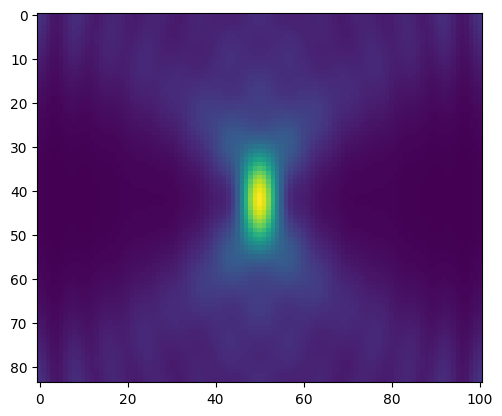

In [122]:
plt.imshow(fitted_PSF.sum(axis=1))

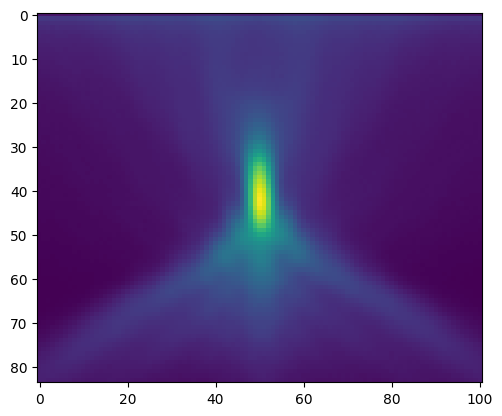

In [123]:
plt.imshow(target_psf.sum(axis=1))

In [124]:
result.x

array([751.91022961,   1.27965015,   1.41579994,   3.        ,
         1.        ])